In [2]:
import torch
import cv2
import numpy as np
import os
from PIL import Image
from torchvision import transforms, models
from utils.cnn_rnn import CNN_RNN_Model

In [6]:
def apply_gabor_filters(image, num_kernels=8):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    resized_gray = cv2.resize(gray, (7, 7))

    feature_maps = []
    for theta in np.linspace(0, np.pi, num_kernels):
        kernel = cv2.getGaborKernel((5, 5), 1.0, theta, 5, 0.5, 0, ktype=cv2.CV_32F)
        filtered = cv2.filter2D(resized_gray, cv2.CV_8UC3, kernel)
        feature_maps.append(filtered)

    return np.array(feature_maps)

def extract_convnext_features(image, transform, device="cuda"):
    convnext = models.convnext_base(weights='IMAGENET1K_V1')
    convnext = torch.nn.Sequential(*list(convnext.children())[:-2])
    convnext.to(device).eval()

    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = convnext(image_tensor)
    
    return features.squeeze(0).cpu().numpy()

def prepare_feature_sequence(image, transform, device="cuda"):
    gabor_features = apply_gabor_filters(image)
    convnext_features = extract_convnext_features(Image.fromarray(image), transform, device)

    _, H, W = convnext_features.shape
    sequence_length = H * W
    
    gabor_seq = gabor_features.reshape(8, -1).T
    convnext_seq = convnext_features.reshape(1024, -1).T
    
    combined_seq = np.concatenate([gabor_seq, convnext_seq], axis=1)
    
    return torch.tensor(combined_seq, dtype=torch.float32).unsqueeze(0)

def load_model(model_type, device="cuda"):
    num_classes_map = {"artist": 23, "genre": 10, "style": 27}
    if model_type not in num_classes_map:
        print(f"[ERROR] Invalid model type: {model_type}. Choose from 'artist', 'genre', or 'style'.")
        return None
    
    num_classes = num_classes_map[model_type]
    
    base_path = os.getcwd()
    model_path = os.path.join(base_path, "weight", "final_weight", f"{model_type}.pth")

    model = CNN_RNN_Model(input_size=1032, hidden_size=256, num_classes=num_classes)
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"[INFO] Model '{model_type}' loaded successfully from {model_path}")
    else:
        print(f"[ERROR] Model not found at {model_path}")
        return None

    model.to(device)
    model.eval()
    return model

def predict(model, sequence_tensor, device):
    sequence_tensor = sequence_tensor.to(device)
    with torch.no_grad():
        output = model(sequence_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

def classify_image(image_path, model_type, device="cuda"):
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    model = load_model(model_type, device=device)
    if not model:
        return None

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"[ERROR] Could not load image: {image_path}")
        return None
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sequence_tensor = prepare_feature_sequence(image, transform, device)
    
    predicted_class = predict(model, sequence_tensor, device)
    print(f"[INFO] Predicted class for '{model_type}': {predicted_class}")
    return predicted_class




In [15]:
# HashMap: Image Path -> Ground Truth Label
ground_truth_map = {
    r"C:\Users\athar\OneDrive\Desktop\Atharva\Github\open_source\humandArt\task1\test_image\claude-monet_water-lilies-1917-4.jpg": 4,
    r"C:\Users\athar\OneDrive\Desktop\Atharva\Github\open_source\humandArt\task1\test_image\camille-corot_the-monk-1874.jpg": 2,
    r"C:\Users\athar\OneDrive\Desktop\Atharva\Github\open_source\humandArt\task1\test_image\frans-hals_portrait-of-a-seated-man.jpg": 4
}

In [16]:
import matplotlib.pyplot as plt

# Class Mappings
artist_mapping = {
    0: "Albrecht_Durer", 1: "Boris_Kustodiev", 2: "Camille_Pissarro", 3: "Childe_Hassam",
    4: "Claude_Monet", 5: "Edgar_Degas", 6: "Eugene_Boudin", 7: "Gustave_Dore",
    8: "Ilya_Repin", 9: "Ivan_Aivazovsky", 10: "Ivan_Shishkin", 11: "John_Singer_Sargent",
    12: "Marc_Chagall", 13: "Martiros_Saryan", 14: "Nicholas_Roerich", 15: "Pablo_Picasso",
    16: "Paul_Cezanne", 17: "Pierre_Auguste_Renoir", 18: "Pyotr_Konchalovsky", 19: "Raphael_Kirchner",
    20: "Rembrandt", 21: "Salvador_Dali", 22: "Vincent_van_Gogh"
}

genre_mapping = {
    0: "abstract_painting", 1: "cityscape", 2: "genre_painting", 3: "illustration",
    4: "landscape", 5: "nude_painting", 6: "portrait", 7: "religious_painting",
    8: "sketch_and_study", 9: "still_life"
}

style_mapping = {
    0: "Abstract Expressionism", 1: "Action Painting", 2: "Analytical Cubism",
    3: "Art Nouveau", 4: "Baroque", 5: "Color Field Painting", 6: "Contemporary Realism",
    7: "Cubism", 8: "Early Renaissance", 9: "Expressionism", 10: "Fauvism",
    11: "High Renaissance", 12: "Impressionism", 13: "Mannerism / Late Renaissance",
    14: "Minimalism", 15: "Naïve Art / Primitivism", 16: "New Realism", 17: "Northern Renaissance",
    18: "Pointillism", 19: "Pop Art", 20: "Post-Impressionism", 21: "Realism",
    22: "Rococo", 23: "Romanticism", 24: "Symbolism", 25: "Synthetic Cubism", 26: "Ukiyo-e"
}



[INFO] Model 'artist' loaded successfully from C:\Users\athar\OneDrive\Desktop\Atharva\Github\open_source\humandArt\task1\weight\final_weight\artist.pth
[INFO] Predicted class for 'artist': 4
[INFO] Model 'genre' loaded successfully from C:\Users\athar\OneDrive\Desktop\Atharva\Github\open_source\humandArt\task1\weight\final_weight\genre.pth
[INFO] Predicted class for 'genre': 2
[INFO] Model 'style' loaded successfully from C:\Users\athar\OneDrive\Desktop\Atharva\Github\open_source\humandArt\task1\weight\final_weight\style.pth
[INFO] Predicted class for 'style': 4


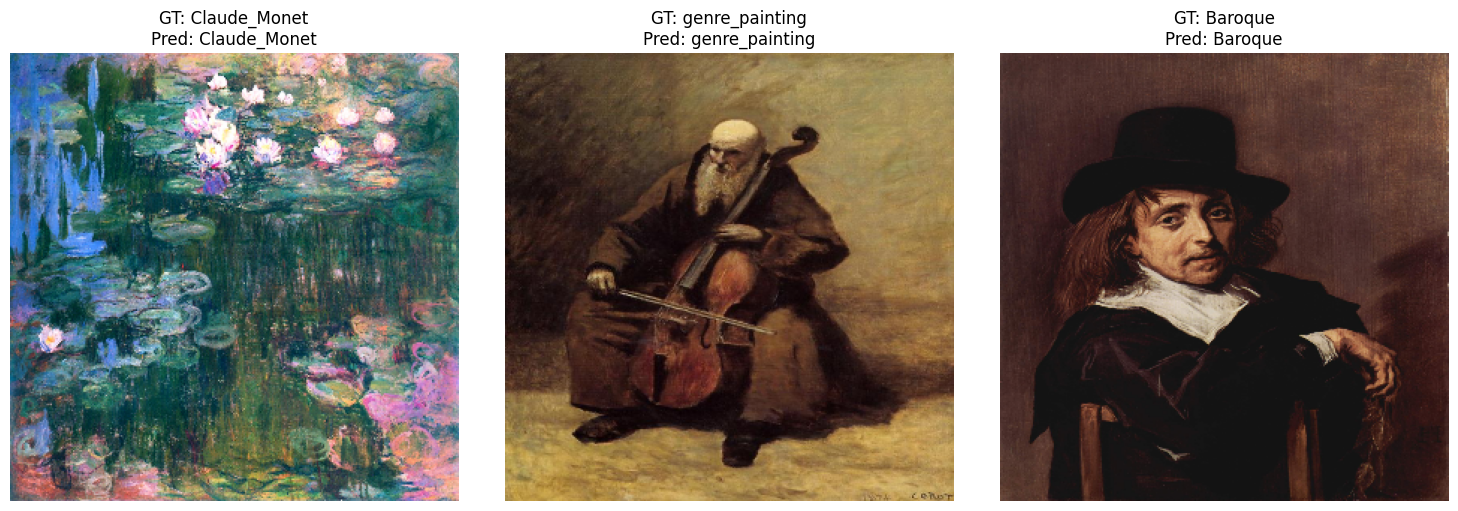

In [26]:
def visualize_predictions(image_paths, ground_truths, save_path=None):
    class_mappings = {"artist": artist_mapping, "genre": genre_mapping, "style": style_mapping}
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (task, img_path) in enumerate(image_paths.items()):
        pred = classify_image(img_path, task)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (300, 300))
        
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"GT: {ground_truths[task]}\nPred: {class_mappings[task][pred]}", fontsize=12, color="black")

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Example usage:
visualize_predictions(image_paths, ground_truths, save_path="predictions.png")


In [27]:
#thsi is how you can run and check the prediction on a single image here 
# pass the image path

img_path = r"C:\Users\athar\OneDrive\Desktop\Atharva\Github\open_source\humandArt\task1\test_image\claude-monet_water-lilies-1917-4.jpg"
task = "artist"
pred = classify_image(img_path, task)

[INFO] Model 'artist' loaded successfully from C:\Users\athar\OneDrive\Desktop\Atharva\Github\open_source\humandArt\task1\weight\final_weight\artist.pth
[INFO] Predicted class for 'artist': 4


In [30]:
print(artist_mapping[pred])

Claude_Monet
